In [197]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os.path
import os
import numpy as np
import pandas as pd
from PIL import Image
import random
import re
import scipy.stats

data_dir = '/data/neon/facebook/video_ads/aquila_features'

In [4]:
weights = pd.read_pickle('/home/mdesnoyer/src/neon3/model/demographics/20160713-aquilav2-weight.pkl')
bias = pd.read_pickle('/home/mdesnoyer/src/neon3/model/demographics/20160713-aquilav2-bias.pkl')

In [5]:
def compute_score_for_demo(X, gender='None', age='None'):
    '''Returns the score for gender `gender` and age `age` derived from
    feature vector X (a numpy array)
    '''

    b = bias[gender, age][0]
    W = weights[gender, age]
    try:
        scores = W.dot(X) + b
    except ValueError as e:
        raise ValueError(e)
    # return score
    # for now, we're nto going to return the score as multiindex 
    # series objects, but simply as floats.
    return scores

In [83]:
def open_features_file(filename):
    data = pd.read_pickle(filename)
    if len(data.shape) == 2:
        data.columns = pd.MultiIndex.from_tuples([('a'+os.path.basename(x[0]).partition('.')[0], x[1]) 
                                                  for x in data.columns])
    else:
        data.name = 'a' + os.path.basename(data.name).partition('.')[0]
    return data

In [55]:
def open_label_file(filename):
    data = pd.read_excel(filename)
    return data.set_index('ID').sort_index()

In [56]:
labels = open_label_file('/home/mdesnoyer/reports/facebook/Neon_Videos.xlsx')

In [79]:
def calculate_frame_scores(data_dir, func=compute_score_for_demo):
    '''Calculates the score by applying func to the matrix in each file in data_dir'''
    data = []
    for fn in os.listdir(data_dir):
        try:
            cur_data = open_features_file(os.path.join(data_dir, fn))
        except IOError:
            continue
        if cur_data.shape[0] == 0:
            print fn
        data.append(func(cur_data))
    return pd.concat(data, axis=0).sort_index()

In [46]:
valence_scores = calculate_frame_scores('/data/neon/facebook/video_ads/aquila_features')
valence_scores = valence_scores.sort_index()

In [53]:
valence_scores = valence_scores.sort_index()
labels = labels.sort_index()

In [68]:
simple_valence_score_agg = valence_scores.groupby(level=0).agg({'max': np.max,
                                                                'median': np.median,
                                                                'mean' : np.mean, 
                                                                '98th' : lambda x: np.percentile(x, 95)})


## Ad Recall Rate for Valence Score

They are negatively correlated

In [138]:
ad_recall_data = simple_valence_score_agg.copy()
ad_recall_data['Ad Recall'] = labels['Ad Recall']
ad_recall_data = ad_recall_data.dropna()
for metric in ['max', 'mean', '98th', 'median']:
    print metric
    print 'Spearman: %f P-value: %f' % scipy.stats.spearmanr(ad_recall_data['Ad Recall'], ad_recall_data[metric])
    print 'Pearson: %f P-value: %f' % scipy.stats.pearsonr(ad_recall_data['Ad Recall'], ad_recall_data[metric])

max
Spearman: -0.234276 P-value: 0.000001
Pearson: -0.165373 P-value: 0.000730
mean
Spearman: -0.125653 P-value: 0.010495
Pearson: -0.123458 P-value: 0.011936
98th
Spearman: -0.218540 P-value: 0.000007
Pearson: -0.155714 P-value: 0.001482
median
Spearman: -0.149080 P-value: 0.002357
Pearson: -0.132824 P-value: 0.006802


## View Rate for Valence Score

We're positively correlated

In [144]:
view_rate_data = simple_valence_score_agg.copy()
view_rate_data['View Rate'] = labels['View Rate']
view_rate_data = view_rate_data.dropna()
for metric in ['max', 'mean', '98th', 'median']:
    print metric
    print 'Spearman: %f P-value: %f' % scipy.stats.spearmanr(view_rate_data['View Rate'], view_rate_data[metric])
    print 'Pearson: %f P-value: %f' % scipy.stats.pearsonr(view_rate_data['View Rate'], view_rate_data[metric])

max
Spearman: 0.140250 P-value: 0.001686
Pearson: 0.156731 P-value: 0.000441
mean
Spearman: 0.024116 P-value: 0.590960
Pearson: 0.103939 P-value: 0.020217
98th
Spearman: 0.093253 P-value: 0.037304
Pearson: 0.116737 P-value: 0.009052
median
Spearman: 0.063951 P-value: 0.153740
Pearson: 0.126910 P-value: 0.004521


In [105]:
label_corr_data = labels[['View Rate', 'Ad Recall']].dropna()
print 'Spearman: %f P-value: %f' % scipy.stats.spearmanr(label_corr_data['View Rate'], label_corr_data['Ad Recall'])
print 'Pearson: %f P-value: %f' % scipy.stats.pearsonr(label_corr_data['View Rate'], label_corr_data['Ad Recall'])

Spearman: 0.037629 P-value: 0.462780
Pearson: 0.032870 P-value: 0.521290


# First 3 Seconds Valence Scores

In [ ]:
first3secs_valence = valence_scores.loc[(slice(None),slice(0, 90))]
first3secs_valence_agg = first3secs_valence.groupby(level=0).agg({'max': np.max,
                                                                'median': np.median,
                                                                'mean' : np.mean, 
                                                                '98th' : lambda x: np.percentile(x, 95)})

## Ad Recall

In [176]:
ad_recall_data = first3secs_valence_agg.copy()
ad_recall_data['Ad Recall'] = labels['Ad Recall']
ad_recall_data = ad_recall_data.dropna()
for metric in ['max', 'mean', '98th', 'median']:
    print metric
    print 'Spearman: %f P-value: %f' % scipy.stats.spearmanr(ad_recall_data['Ad Recall'], ad_recall_data[metric])
    print 'Pearson: %f P-value: %f' % scipy.stats.pearsonr(ad_recall_data['Ad Recall'], ad_recall_data[metric])

max
Spearman: -0.101746 P-value: 0.038515
Pearson: -0.031471 P-value: 0.523104
mean
Spearman: -0.065134 P-value: 0.185942
Pearson: -0.010289 P-value: 0.834664
98th
Spearman: -0.088392 P-value: 0.072399
Pearson: -0.025803 P-value: 0.600620
median
Spearman: -0.053854 P-value: 0.274288
Pearson: 0.004776 P-value: 0.922826


## View Rate

In [212]:
view_rate_data = first3secs_valence_agg.copy()
view_rate_data['View Rate'] = labels['View Rate']
view_rate_data = view_rate_data.dropna()
for metric in ['max', 'mean', '98th', 'median']:
    print metric
    print 'Spearman: %f P-value: %f' % scipy.stats.spearmanr(view_rate_data['View Rate'], view_rate_data[metric])
    print 'Pearson: %f P-value: %f' % scipy.stats.pearsonr(view_rate_data['View Rate'], view_rate_data[metric])

max
Spearman: 0.086034 P-value: 0.054782
Pearson: 0.137333 P-value: 0.002107
mean
Spearman: 0.159951 P-value: 0.000334
Pearson: 0.171554 P-value: 0.000118
98th
Spearman: 0.100470 P-value: 0.024807
Pearson: 0.148594 P-value: 0.000870
median
Spearman: 0.148779 P-value: 0.000857
Pearson: 0.156835 P-value: 0.000437


# Create Data File

In [182]:
outdata = labels.copy()
outdata['Whole Video Neon Score'] = simple_valence_score_agg['98th']
outdata['3s Neon Score'] = first3secs_valence_agg['mean']
outdata.to_pickle('/data/neon/facebook/video_ads/neon_scores.pkl')
outdata.to_csv('/data/neon/facebook/video_ads/neon_scores.csv')
outdata

Ad Recall  View Rate        Test Set  \
ID                                                         
a1008785892468102         2.0        NaN             NaN   
a1013299912016700         NaN        NaN  Ad Recall Only   
a10152308221161836        1.0        5.0             NaN   
a10152358851480378        NaN        NaN            Both   
a10152367337455378        4.0        NaN  View Rate Only   
a10152367449435378        4.0        2.0             NaN   
a10152387488891836        NaN        1.0             NaN   
a10152415861791836        NaN        2.0             NaN   
a10152417385675779        2.0        4.0             NaN   
a10152419510601836        NaN        1.0             NaN   
a10152420227373511        NaN        NaN            Both   
a10152420299363511        4.0        3.0             NaN   
a10152423085131786        2.0        2.0             NaN   
a10152435629435811        5.0        4.0             NaN   
a10152437208141836        NaN        NaN  View Rate Only   
a10152440873106836        NaN        NaN  View Rate Only   
a10152443336941836        NaN        1.0             NaN   
a10152454902306010        5.0        4.0             NaN   
a10152454924196010        NaN        NaN            Both   
a10152458405153231        NaN        NaN            Both   
a10152460752111010        5.0        5.0             NaN   
a10152460759166010        5.0        4.0             NaN   
a10152460880396010        5.0        5.0             NaN   
a10152460889541010        5.0        4.0             NaN   
a10152460893166010        5.0        5.0             NaN   
a10152465621497014        5.0        NaN  View Rate Only   
a10152465630282014        NaN        NaN            Both   
a10152465636257014        5.0        5.0             NaN   
a10152469405408511        4.0        1.0             NaN   
a10152473219348511        NaN        NaN            Both   
...                       ...        ...             ...   
a953124881381502          3.0        1.0             NaN   
a953284301356292          NaN        NaN            Both   
a953286631356059          4.0        1.0             NaN   
a953287211356001          NaN        NaN            Both   
a955136091181740          1.0        3.0             NaN   
a957212024291653          4.0        1.0             NaN   
a957224174290438          NaN        NaN            Both   
a957226057623583          NaN        NaN            Both   
a957369480942574          4.0        1.0             NaN   
a957373840942138          NaN        NaN            Both   
a957375604275295          4.0        1.0             NaN   
a957376197608569          4.0        1.0             NaN   
a957376657608523          NaN        NaN            Both   
a958726964154627          NaN        NaN            Both   
a959754304053252          1.0        2.0             NaN   
a963192537041403          3.0        1.0             NaN   
a964191796942836          1.0        4.0             NaN   
a967221493306533          1.0        2.0             NaN   
a967498629944127          3.0        1.0             NaN   
a967499073277416          3.0        1.0             NaN   
a971581366203879          NaN        NaN            Both   
a971656399528350          3.0        1.0             NaN   
a971658236194833          3.0        1.0             NaN   
a975618279133521          NaN        NaN            Both   
a976109509084171          NaN        NaN            Both   
a976272609054412          2.0        4.0             NaN   
a977291635630186          1.0        5.0             NaN   
a979501095411906          1.0        3.0             NaN   
a979897722038910          NaN        NaN            Both   
a981062908611235          4.0        NaN             NaN   

                    Whole Video Neon Score  3s Neon Score  
ID                                                         
a1008785892468102                -0.126606      -0.728920  
a1013299912016700                 0.148201      -1.012817  

In [119]:
counts.sum(axis=0)

array([ 89.,  77.,  68.,  72.,  77.])

In [145]:
n_trials = 1000
rho_counts = 0.
real_spearman = scipy.stats.spearmanr(view_rate_data['View Rate'], view_rate_data['max'])
print real_spearman
for i in range(n_trials):
    rho = scipy.stats.spearmanr(np.random.permutation(view_rate_data['View Rate']), view_rate_data['max'])
    if rho[0] > real_spearman[0]:
        rho_counts += 1
rho_counts / n_trials

(0.14024950517684828, 0.0016859315622866986)


0.001

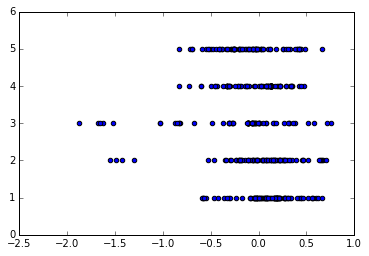

In [163]:
plt.scatter(ad_recall_data['max'], ad_recall_data['Ad Recall'])

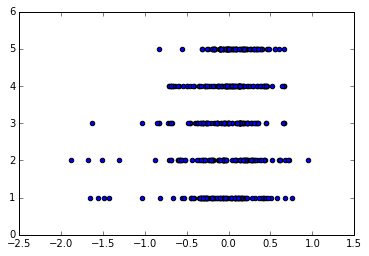

In [164]:
plt.scatter(view_rate_data['max'], view_rate_data['View Rate'])

In [195]:
def get_frame(video_fn, frameno=None):
    '''Returns the approximate middle frame of the video'''
    mov = cv2.VideoCapture(video_fn)
    num_frames = int(mov.get(cv2.CAP_PROP_FRAME_COUNT))
    if frameno is None:
        frameno = int(num_frames/2)
    
    mov.set(cv2.CAP_PROP_POS_FRAMES, frameno)
    success, image = mov.read()
    if not success:
        return np.zeros(10, 10, 3)
    return image[:,:,::-1]
    
    
def show_images(scores, base_dir='/data/neon/facebook/video_ads/vids', frameno=None):
    '''Show top images from descending scores. The index will get me to the filename'''
    scores = scores.sort_values(ascending=False)
    
    fig = plt.figure(2, (20,16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 5))
    i = 0
    for row in scores.index.tolist():
        basename = '%s.mp4' % re.search('[0-9]+', row).group()
        im = Image.fromarray(get_frame(os.path.join(base_dir, basename), frameno=frameno))
        im.thumbnail((200, 200))
        grid[i].imshow(im)
        grid[i].set_xlim(0., 200.)
        grid[i].set_ylim(200., 0.)
        grid[i].axes.get_xaxis().set_ticks([])
        grid[i].axes.get_yaxis().set_ticks([])
        i += 1
        if i >= 20:
            break
    plt.show()

In [242]:
worst_correlation = 2.0, 0.0
worst_correlation_group = None
best_correlation = -2., 0.0
best_correlation_group = None
for i in range(5000):
    samp = ad_recall_data.sample(20)
    val = scipy.stats.spearmanr(samp['98th'], samp['Ad Recall'])
    if val[0] < worst_correlation[0]:
        worst_correlation = val
        worst_correlation_group = samp.copy()
    if val[0] > best_correlation[0]:
        best_correlation = val
        best_correlation_group = samp.copy()

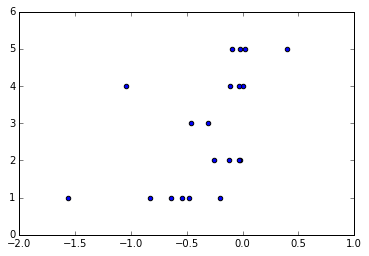

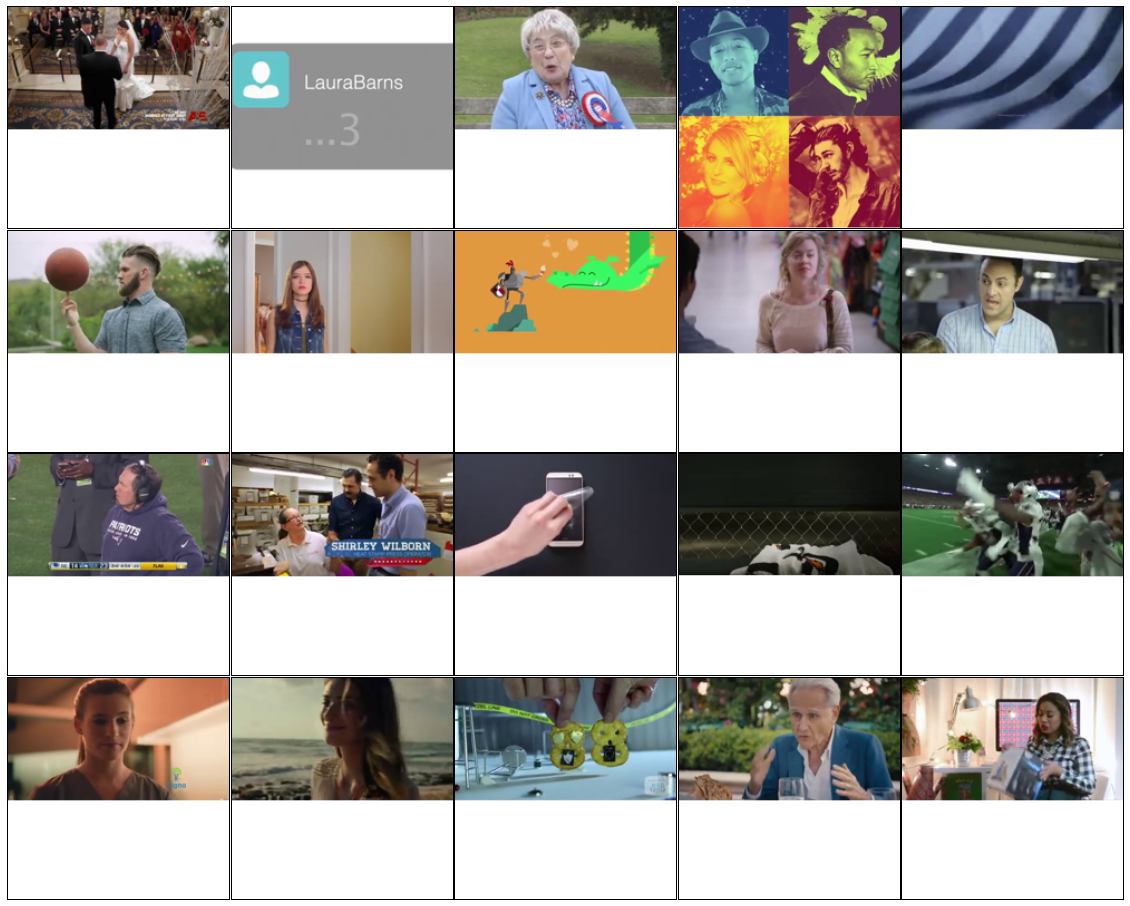

In [243]:
plt.scatter(best_correlation_group['98th'], best_correlation_group['Ad Recall'])
show_images(best_correlation_group['98th'])

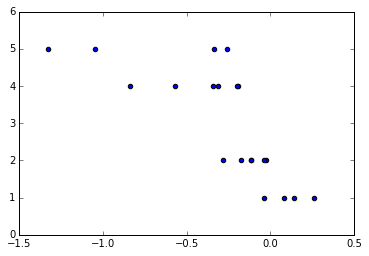

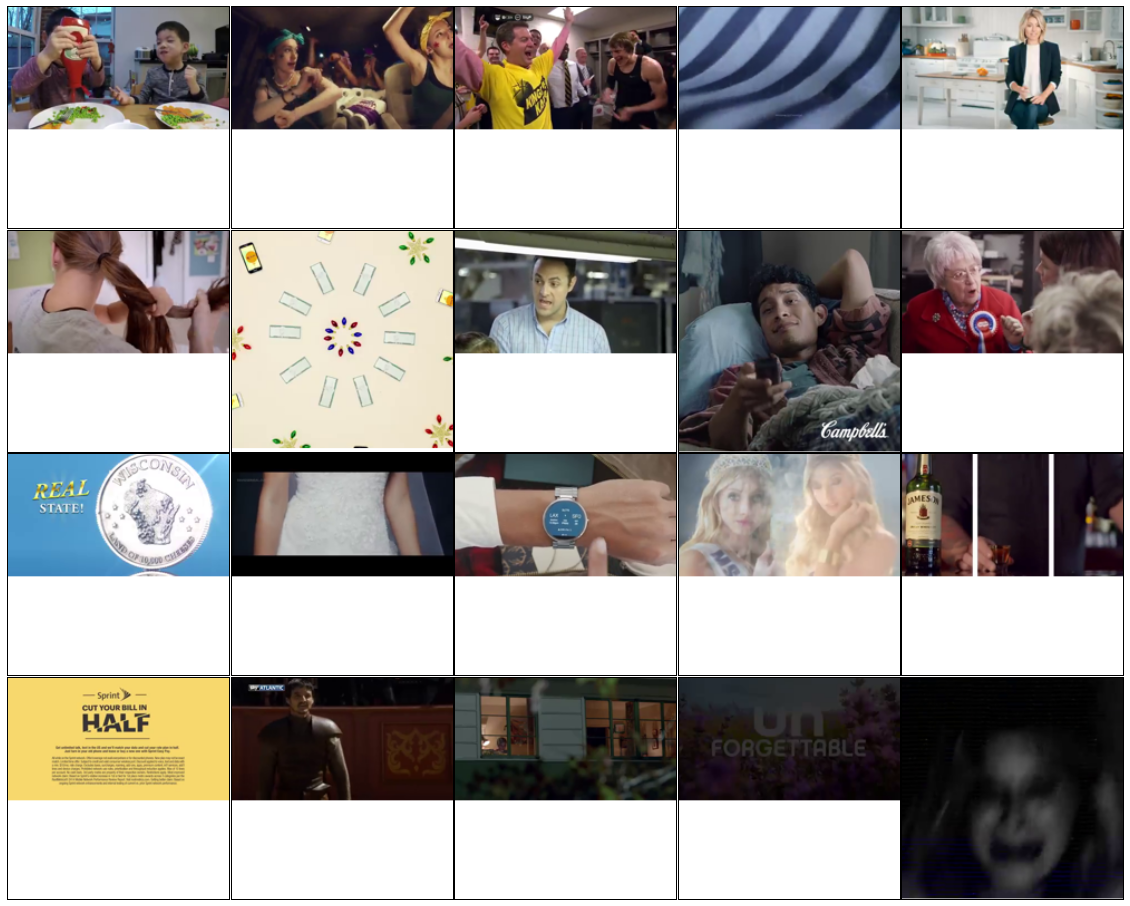

max      98th    median      mean  Ad Recall
a826649627429672   -1.321108 -1.331331 -1.395425 -1.445752        5.0
a830234020401309   -0.780994 -1.047169 -1.631902 -1.697967        5.0
a10152891805626049 -0.834315 -0.836777 -1.200337 -1.420666        4.0
a981062908611235   -0.453658 -0.567452 -1.194974 -1.319703        4.0
a10152785774253511 -0.328494 -0.344013 -0.598108 -1.025939        4.0
a10152863691793731 -0.330536 -0.334717 -0.390027 -0.492835        5.0
a10153098222339489 -0.295504 -0.314447 -0.343304 -0.578520        4.0
a854958037858143   -0.258784 -0.281647 -0.463727 -0.488919        2.0
a10152460880396010 -0.249704 -0.257866 -0.295795 -0.322869        5.0
a10153098223374489 -0.194349 -0.202447 -0.261907 -0.491740        4.0
a10152912243516219 -0.184520 -0.191554 -0.513230 -0.495514        4.0
a10153583639464506 -0.170966 -0.174909 -0.434670 -0.441580        2.0
a879283642103402   -0.114314 -0.118693 -0.170513 -0.313329        2.0
a10152539769198511 -0.036477 -0.115293 -0.757957 -0.798981        2.0
a807330385987247   -0.039873 -0.041576 -0.696609 -0.693305        2.0
a388128668018337   -0.038833 -0.041196 -0.060270 -0.065860        1.0
a339150942925663   -0.003612 -0.023982 -0.259843 -0.287150        2.0
a10153234309528760  0.082864  0.077832 -0.013910 -0.031413        1.0
a836055993074048    0.160186  0.140490 -0.097571 -0.049728        1.0
a812538345495874    0.263758  0.258785  0.156270  0.164344        1.0

In [247]:
plt.scatter(worst_correlation_group['98th'], worst_correlation_group['Ad Recall'])
show_images(worst_correlation_group['98th'])
worst_correlation_group.sort_values('98th')

In [237]:
worst_correlation = 2.0, 0.0
worst_correlation_group = None
best_correlation = -2., 0.0
best_correlation_group = None
for i in range(10000):
    samp = view_rate_data.sample(20)
    val = scipy.stats.spearmanr(samp['mean'], samp['View Rate'])
    if val[0] < worst_correlation[0]:
        worst_correlation = val
        worst_correlation_group = samp.copy()
    if val[0] > best_correlation[0]:
        best_correlation = val
        best_correlation_group = samp.copy()

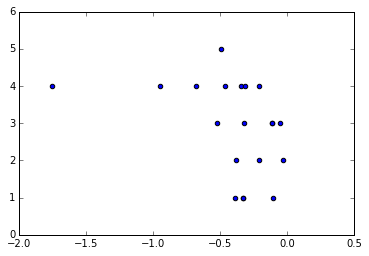

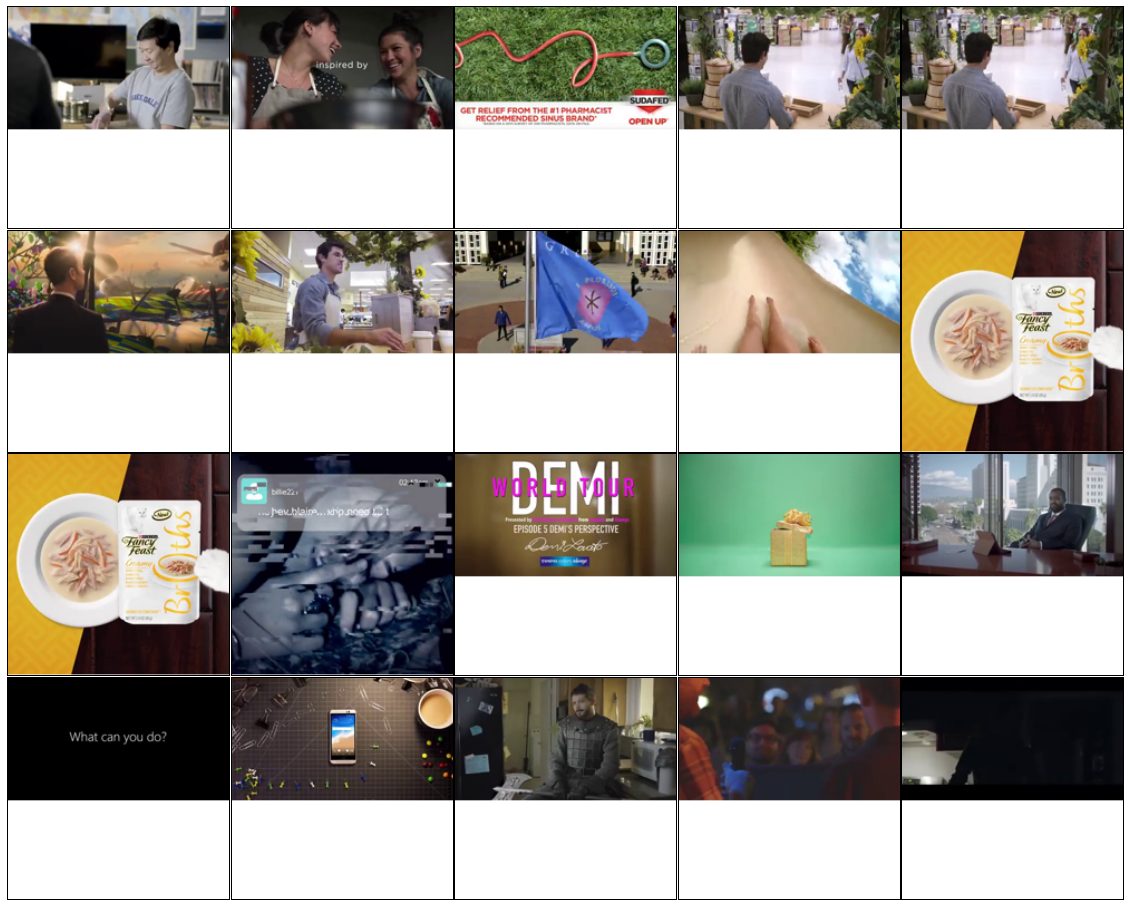

In [239]:
plt.scatter(worst_correlation_group['98th'], worst_correlation_group['View Rate'])
show_images(worst_correlation_group['98th'], frameno=45)

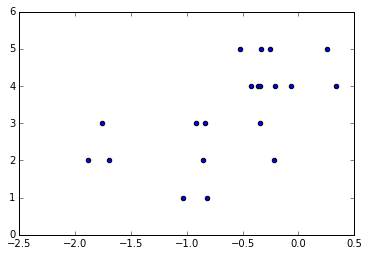

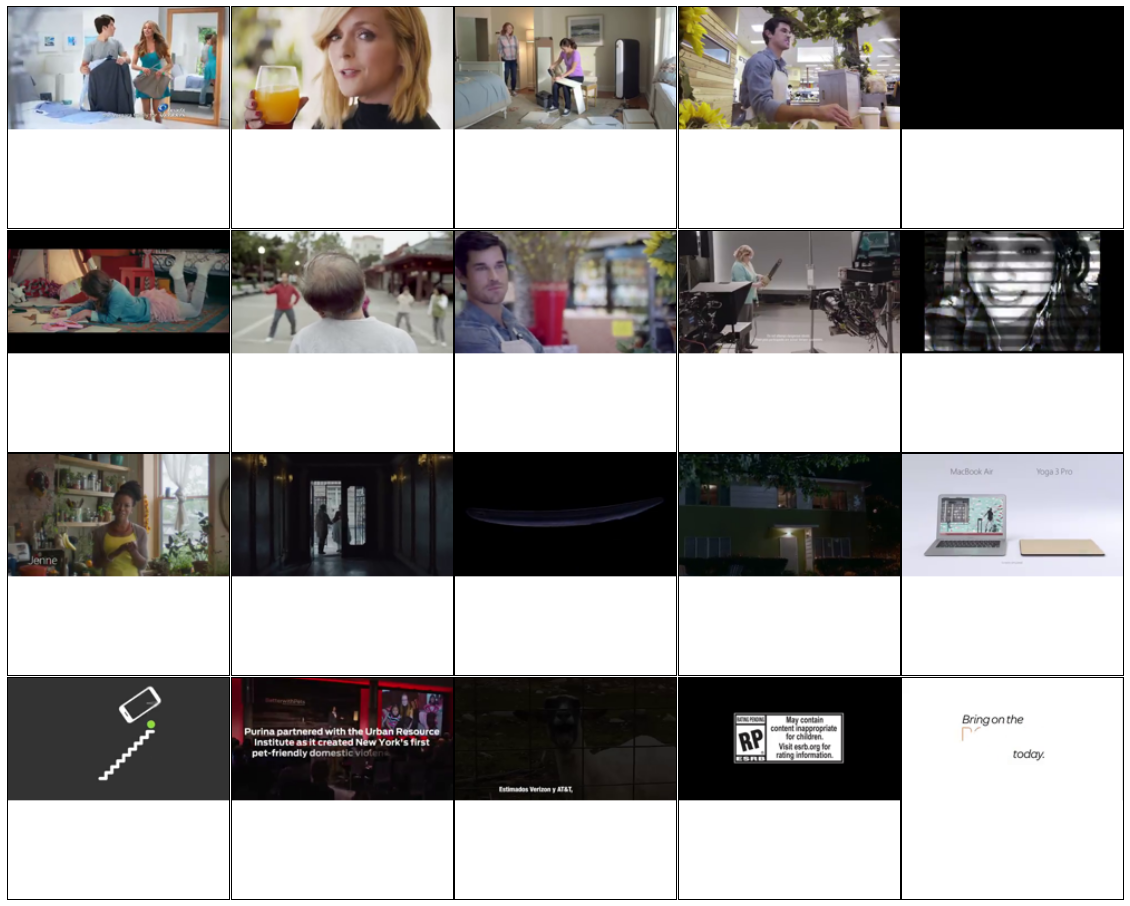

In [238]:
plt.scatter(best_correlation_group['98th'], best_correlation_group['View Rate'])
show_images(best_correlation_group['98th'], frameno=45)

In [229]:
best_correlation_group[best_correlation_group['View Rate'] == 1].sort_values('98th')

KeyError: 'View Rate'

In [159]:
view_rate_data[view_rate_data['View Rate'] == 5]['max'].sort_values()

a905427746141816     -0.830310
a10152997952717415   -0.562327
a1038046456221370    -0.321821
a766744660030454     -0.316617
a10153658233568782   -0.257214
a10152863691793731   -0.248144
a839553949416191     -0.199247
a10152511399218511   -0.194658
a778547615516825     -0.187904
a805974606163841     -0.182297
a809665402405046     -0.178755
a10153271678571729   -0.178755
a839998586038394     -0.174523
a838094699575609     -0.170192
a805709406133979     -0.167377
a10152822986688909   -0.159138
a10153573846594056   -0.106412
a10153573836514056   -0.106412
a10153573874414056   -0.106412
a10153573869999056   -0.106412
a10153573839174056   -0.106412
a10153573844369056   -0.106412
a10153573837789056   -0.106412
a10153573875259056   -0.106412
a10153573827794056   -0.106412
a10153573842364056   -0.106412
a822185597876075     -0.102034
a801212663250320     -0.091619
a895090407182245     -0.089023
a10153581235945260   -0.088188
                        ...   
a695795133834943      0.188427
a1015365

In [253]:
sports_vids = ['10152758417266263',
              '10152758959341263',
              '10152766690726263',
              '10152774447081263',
              '10152774692021263',
              '10152775202866263',
              '10152777985701263',
              '10152778807221263',
              '10152796424696263',
              '10152796562536263',
              '10152796786911263',
              '10152797279836263',
              '10152799915291263',
              '10152815382401263',
              '10152815428976263',
              '10152815475981263',
              '10152815638276263',
              '10152817813306263',
              '10152822801641263',
              '10152827786076263',
              '10152830644111263',
              '10152833387606263',
              '10152833504901263',
              '10152833560196263',
              '10152833584836263',
              '10152833808766263',
              '10152833904291263',
              '10152834148136263',
              '10152834240371263',
              '10152841545101263',
              '10153231258043760',
              '10153233728243760',
              '10153234309528760',
              '10153234625893760',
              '10153243795893760',
              '10153246616943760',
              '10153246831838760',
              '10153248993643760',
              '10153250781938760',
              '10153251069733760',
              '10153265590128760',
              '10153265921463760',
              '10153516996561850',
              '10153526470286850',
              '10153528627826850',
              '10153539694156850',
              '10153551542201850',
              '10153562678526850']

#view_rate_no_sports = first3secs_valence_agg.copy().drop(['a'+x for x in sports_vids], errors='ignore')
view_rate_no_sports = simple_valence_score_agg.copy().drop(['a'+x for x in sports_vids], errors='ignore') 
view_rate_no_sports['View Rate'] = labels['View Rate']
view_rate_no_sports = view_rate_no_sports.dropna()
for metric in ['max', 'mean', '98th', 'median']:
    print metric
    print 'Spearman: %f P-value: %f' % scipy.stats.spearmanr(view_rate_no_sports['View Rate'], 
                                                             view_rate_no_sports[metric])
    print 'Pearson: %f P-value: %f' % scipy.stats.pearsonr(view_rate_no_sports['View Rate'],
                                                           view_rate_no_sports[metric])

max
Spearman: 0.102141 P-value: 0.027304
Pearson: 0.127506 P-value: 0.005792
mean
Spearman: -0.031965 P-value: 0.490764
Pearson: 0.061127 P-value: 0.187286
98th
Spearman: 0.053596 P-value: 0.247706
Pearson: 0.088097 P-value: 0.057119
median
Spearman: -0.003622 P-value: 0.937773
Pearson: 0.082420 P-value: 0.075181


In [255]:
recall_no_sports = simple_valence_score_agg.copy().drop(['a'+x for x in sports_vids], errors='ignore') 
recall_no_sports['Ad Recall'] = labels['Ad Recall']
recall_no_sports = recall_no_sports.dropna()
for metric in ['max', 'mean', '98th', 'median']:
    print metric
    print 'Spearman: %f P-value: %f' % scipy.stats.spearmanr(recall_no_sports['Ad Recall'], 
                                                             recall_no_sports[metric])
    print 'Pearson: %f P-value: %f' % scipy.stats.pearsonr(recall_no_sports['Ad Recall'],
                                                           recall_no_sports[metric])

max
Spearman: -0.218357 P-value: 0.000011
Pearson: -0.150753 P-value: 0.002600
mean
Spearman: -0.098952 P-value: 0.048812
Pearson: -0.102066 P-value: 0.042098
98th
Spearman: -0.209772 P-value: 0.000025
Pearson: -0.146327 P-value: 0.003477
median
Spearman: -0.113218 P-value: 0.024071
Pearson: -0.108257 P-value: 0.031041


# MemNet Scores

Now for interest sake, let's look at the MemNet scores (Aude Olivia's memorability metric) and see how they correlate.

In [92]:
def _add_outer_index(data):
    data.index = pd.MultiIndex.from_tuples([(data.name, x) for x in data.index])
    return data
memnet_scores = calculate_frame_scores('/data/neon/facebook/video_ads/memnet_features', _add_outer_index)

In [93]:
memnet_score_agg = memnet_scores.groupby(level=0).agg({'max': np.max,
                                                       'median': np.median,
                                                       'mean' : np.mean, 
                                                       '98th' : lambda x: np.percentile(x, 95)})

# Memnet vs. Ad Recall Rate

No correlation

In [100]:
ad_recall_data = memnet_score_agg.copy()
ad_recall_data['Ad Recall'] = labels['Ad Recall']
ad_recall_data = ad_recall_data.dropna()
for metric in ['max', 'mean', '98th', 'median']:
    print metric
    print 'Spearman: %f P-value: %f' % scipy.stats.spearmanr(ad_recall_data['Ad Recall'], ad_recall_data[metric])
    print 'Pearson: %f P-value: %f' % scipy.stats.pearsonr(ad_recall_data['Ad Recall'], ad_recall_data[metric])

max
Spearman: -0.100638 P-value: 0.040688
Pearson: -0.073748 P-value: 0.134122
mean
Spearman: 0.090600 P-value: 0.065525
Pearson: 0.069610 P-value: 0.157426
98th
Spearman: -0.006212 P-value: 0.899719
Pearson: -0.006835 P-value: 0.889718
median
Spearman: 0.077640 P-value: 0.114715
Pearson: 0.065240 P-value: 0.185227


## MemNet vs View Rate
No correlation

In [102]:
view_rate_data = memnet_score_agg.copy()
view_rate_data['View Rate'] = labels['View Rate']
view_rate_data = view_rate_data.dropna()
for metric in ['max', 'mean', '98th', 'median']:
    print metric
    print 'Spearman: %f P-value: %f' % scipy.stats.spearmanr(view_rate_data['View Rate'], view_rate_data[metric])
    print 'Pearson: %f P-value: %f' % scipy.stats.pearsonr(view_rate_data['View Rate'], view_rate_data[metric])

max
Spearman: 0.000890 P-value: 0.984177
Pearson: 0.014054 P-value: 0.754149
mean
Spearman: -0.236567 P-value: 0.000000
Pearson: -0.208728 P-value: 0.000003
98th
Spearman: -0.074236 P-value: 0.097634
Pearson: -0.048802 P-value: 0.276566
median
Spearman: -0.255361 P-value: 0.000000
Pearson: -0.237336 P-value: 0.000000
